### setup

In [158]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from IPython.display import clear_output

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

In [159]:
## define paths to data
curr_dir = os.getcwd()
os.path.abspath(os.path.join(curr_dir,'..','..'))

'/home/jefan/neurosketch'

In [160]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '1_object_evidence_during_recognition'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import utils
reload(utils)
utils.data_dir = data_dir
utils.path_to_recog = os.path.join(data_dir, 'features/recog')
utils.path_to_draw = os.path.join(data_dir, 'features/drawing')
utils.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
utils.roi_list_recog = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
utils.roi_list_recog_formatted = np.array(['V1', 'V2', 'LOC', 'FUS','PHC','IT','ENT','PRC','HC']) 
roi_list_recog = utils.roi_list_recog

### get file list

In [161]:
## get raw file list for recognition runs
path_to_recog = utils.path_to_recog

RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] != 'Draw')])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] != 'Draw')])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [27]:
## get raw file list for drawing runs
path_to_draw = utils.path_to_draw

DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] == 'Draw')])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] == 'Draw')])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [28]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
#print('Number of subs: {}'.format(len(sub_list)))

In [29]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [30]:
print 'We have data from {} subjects.'.format(len(sub_list))

We have data from 31 subjects.


### PRODUCTION: How well do we do at classifying the target during production runs when we train on initial recognition patterns only?

In [162]:
reload(utils)
version = '4way'
logged = True

really_run = 0
if really_run:

    ALLDM, Acc = utils.make_drawing_predictions(sub_list,roi_list_recog,
                                            version=version,logged=logged)
    ## save out ALLDM & Acc
    Acc = np.array(Acc)
    np.save(os.path.join(results_dir,'object_classifier_accuracy_production.npy'),Acc)
    ALLDM.to_csv(os.path.join(results_dir,'object_classifier_logprobs_production.csv'),index=False)
    
else:
    ## load in existing ALLDM & Acc 
    Acc = np.load(os.path.join(results_dir,'object_classifier_accuracy_production.npy'))
    ALLDM = pd.read_csv(os.path.join(results_dir,'object_classifier_logprobs_production.csv'))
    
print 'Done!'

Done!


### RECOGNITION: How well do we do at classifying the target during the pre/post recognition runs, trained on initial recognition data?

In [ ]:
reload(utils)
logged = True
version = '4way'

really_run = 1
if really_run:

    ALLPRE, Accpre = utils.make_prepostrecog_predictions_withinphase(sub_list,roi_list_recog,test_phase='pre',logged=logged)
    ALLPOST, Accpost = utils.make_prepostrecog_predictions_withinphase(sub_list,roi_list_recog,test_phase='post',logged=logged)

    ## add raw probs to ALLPRE and ALLPOST dataframes
    append_raw_dict = dict(zip(['t1_prob','t2_prob','c1_prob','c2_prob'],['t1_prob_raw','t2_prob_raw','c1_prob_raw','c2_prob_raw']))
    for key, value in append_raw_dict.iteritems():
        ALLPRE[value] = ALLPRE[key].apply(lambda x: np.exp(x))
        ALLPOST[value] = ALLPOST[key].apply(lambda x: np.exp(x))

    ## save out dataframe
    ALLPRE.to_csv(os.path.join(results_dir,'object_classifier_probs_pre.csv'),index=False) ## train recog, test drawing run    
    ALLPOST.to_csv(os.path.join(results_dir,'object_classifier_probs_post.csv'),index=False) ## train recog, test drawing run    
    ## save out Acc
    np.save(os.path.join(results_dir,'object_classifier_accuracy_pre.npy'),Accpre)
    np.save(os.path.join(results_dir,'object_classifier_accuracy_post.npy'),Accpost)
    Accdiff = np.array(Accpost) - np.array(Accpre)
    np.save(os.path.join(results_dir,'object_classifier_accuracy_diff.npy'),Accdiff)
    print 'Done!' 
    
else:
    ## load in existing ALLPRE, ALLPOST and Acc dataframes
    ALLPRE = pd.read_csv(os.path.join(results_dir,'object_classifier_probs_pre.csv'))
    ALLPOST = pd.read_csv(os.path.join(results_dir,'object_classifier_probs_post.csv'))
    
    Accpre = np.load(os.path.join(results_dir,'object_classifier_accuracy_pre.npy'))
    Accpost = np.load(os.path.join(results_dir,'object_classifier_accuracy_post.npy'))
    Accdiff = np.load(os.path.join(results_dir,'object_classifier_accuracy_diff.npy'))    

Now analyzing fusiform from 1206162 ...
train run: 2, test run: 1


### plot object decoding accuracy across pre, production, and post phases

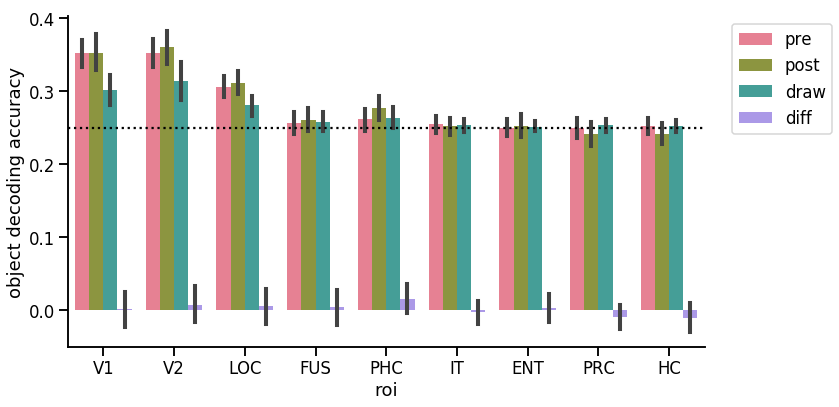

In [210]:
reload(utils)

## aggregate pre, draw, post decoding accuracy
AE = utils.preprocess_acc_array(Accpre,phase='pre')
AD = utils.preprocess_acc_array(Acc,phase='draw')
AO = utils.preprocess_acc_array(Accpost,phase='post')
AF = utils.preprocess_acc_array(Accdiff,phase='diff')

## save out change in decoding accuracy from pre to post to dataframe
A = pd.concat([AE,AD,AO],axis=0)
A2 = pd.concat([AE,AD,AO,AF],axis=0)
A2.to_csv(os.path.join(proj_dir,'csv/object_classifier_accuracy_allphases.csv'))

## generate plot
g = sns.catplot(data=A2,
            x='roi',
            y='acc',
            hue='phase',
            kind='bar',
            hue_order=['pre','post','draw','diff'],
            palette='husl',
            legend=False,
            aspect=2,
            height=6)
plt.legend(bbox_to_anchor=(1.03,1))
plt.ylabel('object decoding accuracy')
plt.axhline(0.25,linestyle=':',color='k')
out_path = os.path.join(proj_dir,'plots/{}/object_classifier_accuracy_bars_allphases.pdf'.format(nb_name))
plt.savefig(out_path,format='pdf')

In [211]:
## print 95% CIs for change in decoding accuracy for each ROI
reload(utils)
roi_list_formatted = ['V1', 'V2', 'LOC', 'FUS', 'PHC', 'IT', 'ENT', 'PRC', 'HC']
for i,roi in enumerate(roi_list_formatted):
    U,lb,ub,p1,p2 = h.bootstrapCI(Accdiff[i,:],nIter=20000)
    print 'ROI:  {}| 95% CI: [{},{}] | p = {}'.format(roi, np.round(lb,5), np.round(ub,5), p1)

ROI:  V1| 95% CI: [-0.02319,0.0246] | p = 0.9294
ROI:  V2| 95% CI: [-0.01633,0.03145] | p = 0.5389
ROI:  LOC| 95% CI: [-0.01875,0.02984] | p = 0.6198
ROI:  FUS| 95% CI: [-0.01915,0.02762] | p = 0.6994
ROI:  PHC| 95% CI: [-0.00423,0.0369] | p = 0.1237
ROI:  IT| 95% CI: [-0.01976,0.0127] | p = 1.215
ROI:  ENT| 95% CI: [-0.01633,0.02278] | p = 0.8338
ROI:  PRC| 95% CI: [-0.0252,0.00726] | p = 1.7164
ROI:  HC| 95% CI: [-0.02944,0.00907] | p = 1.6981


### add handy columns to dataframe (e.g., target probability)

In [212]:
## note, this cell takes a while to run ... 
reload(utils)
ALLPRE = utils.add_target_prob_column(ALLPRE)
ALLPOST = utils.add_target_prob_column(ALLPOST)
print 'Done!'

KeyError: 'bed'

In [207]:
## post processing on the mega dataframes for pretty plotting
ALLPRE['phase'] = 'pre'
ALLPOST['phase'] = 'post'
ALLPREPOST = pd.concat([ALLPRE,ALLPOST],axis=0)

## add formatted ROI list
roi_list = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
roi_list_formatted = ['V1', 'V2', 'LOC', 'FUS', 'PHC', 'IT', 'ENT', 'PRC', 'HC']
roi_formatter = dict(zip(roi_list,roi_list_formatted))
ALLPREPOST['roi_formatted'] = ALLPREPOST['roi'].apply(lambda x: roi_formatter[x])

## add max prob column to dataframe
ALLPREPOST['max_prob_raw'] = ALLPREPOST[['t1_prob_raw','t2_prob_raw','c1_prob_raw','c2_prob_raw']].max(axis=1)

## add correct column, assuming classifier deterministically takes top probability object
ALLPREPOST['correct'] = ALLPREPOST['max_prob_raw']==ALLPREPOST['target_prob_raw']

KeyError: nan

In [ ]:
## define accuracy dataframe for each roi, subject, phase, roi
ALLPREPOSTACC = ALLPREPOST.groupby(['roi_formatted','subj','phase','trained'])['correct'].mean().reset_index()
ALLPREPOSTACC.to_csv(os.path.join(results_dir,'object_classifier_prepost_accuracy.csv'),index=False)

## define mean target probability dataframe for each roi, subject, phase, roi
ALLPROBS = ALLPREPOST.groupby(['roi_formatted','subj','phase','trained'])['target_prob_raw'].mean().reset_index()
ALLPROBS['foil_prob_raw'] = ALLPREPOST.groupby(['roi_formatted','subj','phase','trained'])['foil_prob_raw'].mean().reset_index()['foil_prob_raw']
ALLPROBS.to_csv(os.path.join(results_dir,'object_classifier_prepost_rawprobs.csv'),index=False)

In [ ]:
g = sns.catplot(data=ALLPREPOST, 
            x = 'roi_formatted',
            y = 'target_prob_raw',
            hue = 'phase',
            col = 'trained',
            col_order = [True,False],
            kind = 'bar',
            legend=False,
            aspect = 1.5,
            palette = 'husl')

def refline(*args, **kwargs):
    plt.axhline(0.25,linestyle=':',color='k')    

g = g.map(refline)    
g = (g.set_axis_labels("", 'classifier probability'))
plt.legend()
    

In [ ]:
g = sns.catplot(data=ALLPREPOSTACC, 
            x = 'roi_formatted',
            y = 'correct',
            hue = 'phase',
            col = 'trained',
            col_order = [True,False],
            order = roi_list_formatted,
            hue_order = ['pre','post'],
            kind = 'bar',
            legend=False,
            aspect = 1.5,
            palette = 'husl')

def refline(*args, **kwargs):
    plt.axhline(0.25,linestyle=':',color='k')    

g = g.map(refline)    
g = (g.set_axis_labels("", 'classifier probability'))
plt.legend()

### generate object classifier prediction dataframes and save to file

In [54]:
reload(utils)
dpre = utils.get_log_odds(ALLPRE,
               this_iv = 'time_point',
               roi_list = roi_list_recog,
               phase = 'pre',
               version='4way',
               logged=True,
               proj_dir=proj_dir)

roi
IT           1.101942
LOC          1.647574
PRC          0.998642
V1           2.919819
V2           3.125036
ento         0.997732
fusiform     1.402298
hipp         1.072089
parahippo    1.005799
Name: target-foil, dtype: float64


In [55]:
reload(utils)
dpre = utils.get_log_odds(ALLPOST,
               this_iv = 'time_point',
               roi_list = roi_list_recog,
               phase = 'post',
               version='4way',
               logged=True,
               proj_dir=proj_dir)

roi
IT           1.183426
LOC          2.042075
PRC          1.213002
V1           3.426638
V2           3.525316
ento         1.144529
fusiform     1.505844
hipp         1.076033
parahippo    1.367859
Name: target-foil, dtype: float64


In [122]:
def make_prepostrecog_predictions_withinphase(sub_list,roi_list,version='4way',test_phase='pre',logged=True):
    '''
    input:
        sub_list: a list containing subject IDs
        roi_list: a list containing roi names
        version: a string from options: ['4way','3way','2way']
            4way: trains to discriminate all four objects from recognition runs
        test_phase: which recognition phase to test on, "pre" or "post"
        logged: boolean. If true, return log-probabilities. If false, return raw probabilities.

    assumes: that you have directories containing recognition run and drawing run data, consisting of paired .npy
                voxel matrices and .csv metadata matrices
    '''

    ## Handle slightly different naming for same ROIs in the drawing/recog data directories

    # ROI labels in the recog data directory
    roi_list_recog = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'ParietalDraw', 
                         'supraMarginalDraw', 'postCentralDraw', 'preCentralDraw', 'FrontalDraw'])
  
    # initialize "All Data Matrix"
    ALLDM = []
    ## loop through all subjects and rois
    Acc = []
    for this_roi in roi_list:
        clear_output(wait=True)
        acc = []
        for this_sub in sub_list:
            ## load subject data in
            DM, DF = utils.load_draw_data(this_sub,this_roi)
            if test_phase=='pre':
                RM, RF = utils.load_recog_data(this_sub,this_roi,'34')
            elif test_phase=='post':
                RM, RF = utils.load_recog_data(this_sub,this_roi,'56')            
            else:
                print 'Invalid test split, test_phase should be either "pre" or "post." '

            ## loop through train/test split
            for name, group in RM.groupby('run_num'):
                print('Now analyzing {} from {} ...'.format(this_roi, this_sub))    
                print 'train run: {}, test run: {}'.format(name, np.setdiff1d([1,2],name)[0])
                clear_output(wait=True)

                ## train/test split by run
                RMtrain = group 
                RFtrain = RF[RMtrain.index,:]
                RMtest = RM[RM['run_num']==np.setdiff1d([1,2],name)[0]] 
                RFtest = RF[RMtest.index,:]
                assert RFtrain.shape[0]==RFtest.shape[0]    

                # identify control objects (the only use of DM in this function)
                trained_objs = np.unique(DM.label.values)
                control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]

                probs = []
                logprobs = []

                ## normalize voxels within task
                normalize_on = 1
                if normalize_on:
                    _RFtrain = normalize(RFtrain)
                    _RFtest = normalize(RFtest)
                else:
                    _RFtrain = RFtrain
                    _RFtest = RFtest

                # single train/test split
                X_train = _RFtrain
                y_train = RMtrain.label.values

                X_test = _RFtest
                y_test = RMtest.label.values
                clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)

                ## add prediction probabilities to metadata matrix
                cats = clf.classes_
                probs = clf.predict_proba(X_test)

                ## add prediction probabilities to metadata matrix
                ## must sort so that trained are first, and control is last
                cats = list(clf.classes_)
                _ordering = np.argsort(np.hstack((trained_objs,control_objs))) ## e.g., [chair table bench bed] ==> [3 2 0 1]
                ordering = np.argsort(_ordering) ## get indices that sort from alphabetical to (trained_objs, control_objs)
                probs = clf.predict_proba(X_test)[:,ordering] ## [table chair bed bench]
                logprobs = np.log(clf.predict_proba(X_test)[:,ordering])                               

                if logged==True:
                    out = logprobs
                else:
                    out = probs

                RM.at[RMtest.index,'t1_prob'] = out[:,0]
                RM.at[RMtest.index,'t2_prob'] = out[:,1]
                RM.at[RMtest.index,'c1_prob'] = out[:,2]   
                RM.at[RMtest.index,'c2_prob'] = out[:,3]

                ## also save out new columns in the same order
                if logged==True:
                    probs = np.log(clf.predict_proba(X_test))
                else:
                    probs = clf.predict_proba(X_test)
                RM.at[RMtest.index,'bed_prob'] = probs[:,0]
                RM.at[RMtest.index,'bench_prob'] = probs[:,1]
                RM.at[RMtest.index,'chair_prob'] = probs[:,2]
                RM.at[RMtest.index,'table_prob'] = probs[:,3]

                ## add identity of trained objects and control objects to dataframe
                RM.at[RMtest.index,'t1_name'] = trained_objs[0]
                RM.at[RMtest.index,'t2_name'] = trained_objs[1]
                RM.at[RMtest.index,'c1_name'] = control_objs[0]
                RM.at[RMtest.index,'c2_name'] = control_objs[1]            

                RM.at[RMtest.index,'subj'] = np.repeat(this_sub,len(RMtest.index))
                RM.at[RMtest.index,'roi'] = np.repeat(this_roi,len(RMtest.index))                        

                if len(ALLDM)==0:
                    ALLDM = RMtest
                else:
                    ALLDM = pd.concat([ALLDM,RMtest],ignore_index=True)

                acc.append(clf.score(X_test, y_test))

            Acc.append(np.mean(acc)) ## mean accuracy over both splits
            print len(Acc)
        
    Acc = np.array(Acc)
    return ALLDM, Acc

def normalize(X):
    '''
    z-score normalization to de-mean & standardize variances within-voxel
    '''
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X


In [117]:
acc.append(clf.score(X_test, y_test))

In [121]:
clf.score(X_test, y_test)

1.0

In [104]:
RM.at[RMtest.index,'t1_prob'] = out[:,0]

In [105]:
RM

,subj,label,run_num,TR_num,t1_prob
0,111171,table,1,8.0,-10.226150
1,111171,chair,1,12.0,-1.516758
2,111171,bed,1,14.0,-0.541055
3,111171,bench,1,17.0,-0.777732
4,111171,chair,1,19.0,-1.950745
5,111171,bed,1,22.0,-0.608968
6,111171,bench,1,25.0,-2.506850
7,111171,table,1,28.0,-0.464847
8,111171,chair,1,31.0,-0.719323
9,111171,bed,1,34.0,-3.724415
